In [ ]:
#setup 
!pip install --upgrade --force-reinstall zstandard cuda-python
!pip install -q condacolab alv phylo-treetime
!mamba install -c bioconda mafft iqtree seqkit --quiet
import condacolab
condacolab.install()

  Using cached zstandard-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached cuda_python-12.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached zstandard-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.4 MB)
Using cached cuda_python-12.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.2 MB)
  Attempting uninstall: zstandard
    Found existing installation: zstandard 0.22.0
    Uninstalling zstandard-0.22.0:
      Successfully uninstalled zstandard-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [ ]:
datafile = "/content/Dataset1.fasta" #load data

In [4]:
!head Dataset1.fasta #inspecting input data

>A/Bald_Eagle/BC/OTH-33-36/2022_H5N1|A/Bald_Eagle/BC/OTH-33-36/2022|2022-02-03|
AGCAAAAGCAGGGGTTCACTCTGTCAAAATGGAGAACATAGTACTTCTTCTTGCAATAATTAGCCTTGTTAAAAGTGATCAGATTTGCATTGGTTACCATGCAAACAATTCGACAGAGCAGGTTGACACGATAATGGAAAAGAACGTCACCGTTACACATGCCCAAGACATACTGGAAAAAACACACAACGGGAAGCTCTGTGATCTAAATGGGGTGAAGCCTCTGATTTTAAAGGATTGTAGTGTAGCTGGATGGCTCCTCGGAAACCCAATGTGCGACGAATTCATCAGAGTGCCGGAATGGTCCTACATAGTGGAGCGGGCTAATCCAGCTAATGACCTCTGTTACCCAGGGAGCCTCAATGACTACGAAGAACTGAAACACCTGTTGAGCAGAATAAATCACTTTGAGAAGATTCTGATCATCCCCAAGAGTTCCTGGCCAAATCATGAAACATCACTAGGGGTGAGCGCAGCTTGTCCATACCAGGGAGCGCCCTCCTTTTTCAGAAATGTGGTGTGGCTTATCAAAAAGAACGATGCATACCCAACAATAAAGATAAGCTACAATAATACCAATCGGGAAGATCTCTTGATACTGTGGGGGATTCATCATTCCAACAATGCAGAAGAGCAGACAAATCTCTATAAAAACCCAACCACCTACATTTCAGTTGGAACATCAACTTTAAACCAGAGGTTGGTACCAAAAATAGCTACTAGATCCCAAGTAAACGGGCAACGTGGAAGAATGGACTTCTTCTGGACAATTTTAAAACCAGATGATGCCATCCATTTCGAGAGTAATGGAAATTTCATTGCTCCAGAATATGCATACAAAATTGTCAAGAAAGGGGACTCAACAATTATGAAAAGTGGAGTGGAATATGGCCACTGCAACACCAAATGTCAAACCCCAG

In [6]:
# seqkit inspection
!seqkit stats --all Dataset1.fasta

file            format  type  num_seqs  sum_len  min_len  avg_len  max_len     Q1     Q2     Q3  sum_gap    N50  N50_num  Q20(%)  Q30(%)  AvgQual  GC(%)
Dataset1.fasta  FASTA   DNA         43   76,118    1,757  1,770.2    1,816  1,763  1,770  1,776        0  1,770        6       0       0        0  42.14


In [7]:
# remove gaps
!seqkit seq  --remove-gaps  Dataset1.fasta > Dataset1.dna.fasta && cp Dataset1.dna.fasta Dataset1.fasta

### Python seq import

In [ ]:
#loading sequences 
def read_fasta(input_file):
  sequences = {}
  with open(input_file, "r") as f:
      for line in f:
          if line.startswith(">"):
              header = line.strip()[1:] # Why?
              sequences[header] = ""
          else:
              sequences[header] += line.strip()

  return sequences

sequences = read_fasta(datafile)

print("Number of sequences: ", len(sequences))
print("Min length ", min(len(seq) for seq in sequences.values()))
print("Max length ", max(len(seq) for seq in sequences.values()))
print("Average length ", sum(len(seq) for seq in sequences.values())/len(sequences))

Number of sequences:  43
Min length  1757
Max length  1816
Average length  1770.1860465116279




We will retain sequences with < %10 ambiguous nucleotides defined as (W, S, K, M, Y, R, V, H, D, B, or N). The code is from the original pipeline.

In [9]:
from collections import Counter

with open("sequence_to_filter.txt", "w") as f:
  for header, sequence in sequences.items():
      non_ambiguous_count = sum(sequence.count(char) for char in "ACTG")
      count = len(sequence) - non_ambiguous_count # ambiguous_count
      # Sequences with > 10% ambiguous nucleotides
      if count > 1:
          print(f"{header}: {count} ambiguous nucleotides")
      if count / len(sequence) > 0.1:
          print(f"Removing {header}: {count} ambiguous nucleotides")
          f.write(header + "\n")

# Filter selected sequences
!seqkit grep -v -f sequence_to_filter.txt Dataset1.fasta > Dataset1.filtered.fasta && cp Dataset1.filtered.fasta Dataset1.fasta

A/Cooper_s_Hawk/BC/AIVPHL-893/2023|2023-01-16|: 3 ambiguous nucleotides
[WARN] 0 patterns loaded from file


Running MAFFT on auto and directing output

In [11]:
!mafft --thread -1 --auto Dataset1.fasta > Dataset1.aligned.fasta && cp Dataset1.aligned.fasta Dataset1.aln

OS = linux
The number of physical cores =  1
outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
All-to-all alignment.
tbfast-pair (nuc) Version 7.525
alg=L, model=DNA200 (2), 2.00 (6.00), -0.10 (-0.30), noshift, amax=0.0
1 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   40 / 43
done.

Progressive alignment ... 
STEP    42 /42 (thread    0) 
done.
tbfast (nuc) Version 7.525
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 1
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
generating a scoring matrix for nucleotide (dist=200) ... done

   40 / 43


#### MAFFT OUTPUT
 Alignment was run on a single thread (`nthread = 1`). A matrix was generated for nucleotide sequences with a gap opening penalty of `-1.53`.L-INS-i was chose strategy as it accurate and suitable for less than 200 sequences.

In [12]:
!head Dataset1.aln

>A/Bald_Eagle/BC/OTH-33-36/2022_H5N1|A/Bald_Eagle/BC/OTH-33-36/2022|2022-02-03|
agcaaaagcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataat
tagccttgttaaaagtgatcagatttgcattggttaccatgcaaacaattcgacagagca
ggttgacacgataatggaaaagaacgtcaccgttacacatgcccaagacatactggaaaa
aacacacaacgggaagctctgtgatctaaatggggtgaagcctctgattttaaaggattg
tagtgtagctggatggctcctcggaaacccaatgtgcgacgaattcatcagagtgccgga
atggtcctacatagtggagcgggctaatccagctaatgacctctgttacccagggagcct
caatgactacgaagaactgaaacacctgttgagcagaataaatcactttgagaagattct
gatcatccccaagagttcctggccaaatcatgaaacatcactaggggtgagcgcagcttg
tccataccagggagcgccctcctttttcagaaatgtggtgtggcttatcaaaaagaacga


In [13]:
!seqkit stats Dataset1.aln

file          format  type  num_seqs  sum_len  min_len  avg_len  max_len
Dataset1.aln  FASTA   DNA         43   78,346    1,822    1,822    1,822


In [15]:
# Run alv to shown the start of the alignment
!alv -sa 0 100 -as 0 20 -w 1000 Dataset1.aln


A/Bald_Eagle/BC/OTH- agcaaaagcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Aomori/21C -----aagcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/Chicken/BC/FAV-036 --caaaagcaggggttcactctgtcaaaatggagaacatagtactacttcttgcaatagttagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Iwate/21A1 ------agcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Iwate/21A2 ------agcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Iwate/21A7 ------agcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Iwate/21A1 ------agcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Japan/TU16 -----aagcaggggttcactctgtcaaaatggagaacatagtacttcttcttgcaataattagccttgttaaaagtgatcagatttgcattggttaccat
A/chicken/Japan/TU20 ---

In [16]:
# Run alv to shown the end of the alignment
!alv -sa 1722 1822 -as 0 20 -w 1000 Dataset1.aln

A/Bald_Eagle/BC/OTH- ttgcatttagatttgtgagctcagattgtagttaaaaacacccttgtttctact----------------------------------------------
A/chicken/Aomori/21C ttgcatttagatttgtgagctcagattgtagttaaaaacacccttgtt----------------------------------------------------
A/Chicken/BC/FAV-036 ttgcatttagatttgtgagctcagattatagttaaaaacacccttgtttctac-----------------------------------------------
A/chicken/Iwate/21A1 ttgcatttagatttgtgagctcagattgtagttaaaaacacccttg------------------------------------------------------
A/chicken/Iwate/21A2 ttgcatttagatttgtgagctcagattgtagttaaaaacacccttg------------------------------------------------------
A/chicken/Iwate/21A7 ttgcatttagatttgtgagctcagattgtagttaaaaacacccttg------------------------------------------------------
A/chicken/Iwate/21A1 ttgcatttagatttgtgagctcagattgtagttaaaaacacccttg------------------------------------------------------
A/chicken/Japan/TU16 ttgcatttagatttgtgagctcagattgtagttaaaaacacccttgttt---------------------------------------------------
A/chicken/Japan/TU20 ttg

### Trimming by using first seq as reference.  

In [17]:
!seqkit head -n 1 Dataset1.aln | seqkit locate -Pdip '(N)' | head -n2 # find the first base i.e. not a gap
!seqkit head -n 1 Dataset1.aln | seqkit locate -Pdip '(N)' | tail -n1 # find the last base i.e. not a gap

seqID	patternName	pattern	strand	start	end	matched
A/Bald_Eagle/BC/OTH-33-36/2022_H5N1|A/Bald_Eagle/BC/OTH-33-36/2022|2022-02-03|	(N)	(N)	+	1	1	a
A/Bald_Eagle/BC/OTH-33-36/2022_H5N1|A/Bald_Eagle/BC/OTH-33-36/2022|2022-02-03|	(N)	(N)	+	1776	1776	t


In [18]:
start, *_ = !seqkit head -n 1 Dataset1.aln | seqkit locate -Pdip '(N)' | sed -n '2p' | awk '{print $5}'
end, *_ = !seqkit head -n 1 Dataset1.aln | seqkit locate -Pdip '(N)' | sed -n '$p' | awk '{print $5}'
!seqkit -w 0 subseq -r $start:$end Dataset1.aln > Dataset1.trimmed.aln && cp Dataset1.trimmed.aln Dataset1.aln

[INFO] create or read FASTA index ...
[INFO] create FASTA index for Dataset1.aln
[INFO]   43 records loaded from Dataset1.aln.seqkit.fai


In [19]:
!seqkit stats Dataset1.aln

file          format  type  num_seqs  sum_len  min_len  avg_len  max_len
Dataset1.aln  FASTA   DNA         43   76,368    1,776    1,776    1,776


To filter poorly aligned sequences we use [Biopython](https://biopython.org/). and do it using following script. This code has been reused from original pipeline.

In [22]:
from Bio import AlignIO
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Load the MSA file
alignment = AlignIO.read("Dataset1.aln", "fasta")

# Select the first sequence as the reference
reference_seq = alignment[0].seq

# Define a similarity threshold (e.g., 90%)
threshold = 0.6

def calculate_similarity(seq1, seq2):
    """Calculate the similarity score between two sequences."""
    matches = sum(res1 == res2 for res1, res2 in zip(seq1, seq2))
    return matches / len(seq1)

# Filter sequences
filtered_sequences = []
for record in alignment:
    similarity = calculate_similarity(reference_seq, record.seq)
    if similarity >= threshold:
        filtered_sequences.append(record)
    else:
        print(f"Removing sequence {record.id} with similarity {similarity:.2f}")

# Save the filtered sequences to a new FASTA file
with open("Dataset1.clean.aln", "w") as output_handle:
    SeqIO.write(filtered_sequences, output_handle, "fasta")

In [23]:
!seqkit stats Dataset1.clean.aln  #appears that no sequences were removed since num_seqs is still 43

file                format  type  num_seqs  sum_len  min_len  avg_len  max_len
Dataset1.clean.aln  FASTA   DNA         43   76,368    1,776    1,776    1,776


In [25]:
!iqtree -s Dataset1.aln -m TEST -B 100000 -redo

#100,000 replicated using ultra fast bootstrap. Redo was done since I had already ran it once and output had been generated

IQ-TREE multicore version 2.3.6 for Linux x86 64-bit built Aug  4 2024
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor, Heiko Schmidt,
Dominik Schrempf, Michael Woodhams, Ly Trong Nhan, Thomas Wong

Host:    d063f6b6905d (AVX2, FMA3, 12 GB RAM)
Command: iqtree -s Dataset1.aln -m TEST -B 100000 -redo
Seed:    509250 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Oct 21 00:38:27 2024
Kernel:  AVX+FMA - 1 threads (2 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 2 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file Dataset1.aln ... Fasta format detected
Reading fasta file: done in 0.00140151 secs using 90.33% CPU
Alignment most likely contains DNA/RNA sequences
Alignment has 43 sequences with 1776 columns, 75 distinct patterns
22 parsimony-informative, 48 singleton sites, 1706 constant sites
                                                            

In [26]:
!iqtree -con Dataset1.aln.treefile -minsup 0.5  #majority rule consensus based on 0.5 threshold

IQ-TREE multicore version 2.3.6 for Linux x86 64-bit built Aug  4 2024
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor, Heiko Schmidt,
Dominik Schrempf, Michael Woodhams, Ly Trong Nhan, Thomas Wong

Host:    d063f6b6905d (AVX2, FMA3, 12 GB RAM)
Command: iqtree -con Dataset1.aln.treefile -minsup 0.5
Seed:    242244 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Oct 21 01:01:52 2024
Kernel:  AVX+FMA - 1 threads (2 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 2 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading tree(s) file Dataset1.aln.treefile ...
1 tree(s) loaded (0 rooted and 1 unrooted)
0 split(s) discarded because frequency <= 0.500
83 splits found
Consensus tree written to Dataset1.aln.treefile.contree
Date and Time: Mon Oct 21 01:01:52 2024


## Chronogram


In [51]:
import re

def extract_date(header):
    # Regex to match the date in the format YYYY-MM-DD
    date_match = re.search(r'\d{4}-\d{2}-\d{2}', header)
    if date_match:
        return date_match.group(0)
    else:
        return ""  # In case no date is found, return empty

with open("Dataset1.metadata", "w") as f:
    f.write("name,date\n")
    for line in open("Dataset1.aln"):
        if not line.startswith(">"):
            continue
        header = line.strip()[1:]  # Remove the ">"
        date = extract_date(header)  # Extract the date using regex
        f.write(f"{header},{date}\n")


In [29]:
!treetime --tree Dataset1.aln.treefile.contree --dates Dataset1.metadata --aln Dataset1.aln --outdir timetree #compiling tree, metadta and alignment and directing ouput to folder.


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.00	-TreeAnc: set-up

0.28	TreeTime.reroot: with method or node: least-squares

0.28	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

0.36	TreeTime.reroot: with method or node: least-squares

0.36	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

0.55	###TreeTime.run: INITIAL ROUND

1.27	TreeTime.reroot: with method or node: least-squares

1.27	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

1.37	###TreeTime.run: rerunning timetree after rerooting

2.19	###TreeTime.run: ITERATION 1 out of 2 iterations

2.19	DEPRECATION WARNING. TreeTime.resolve_polytomies: You are resolving
    	polytomies using the old 'greedy' mode. This is not well suited for large
    	polytomies. Stochastic resolution will become the default in future
    	versions. To switch now, rerun with the flag `--stocha

In [30]:
%load_ext rpy2.ipython

In [31]:
%%R

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
    }
if (system.file(package = "ggtree") == '') {
        BiocManager::install("ggtree",quiet = TRUE)
    }
if (system.file(package = "treeio") == '') {
        BiocManager::install("treeio",quiet = TRUE)
    }

install.packages("ggnewscale")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.25.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 593414 bytes (579 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


Update all/some/none? [a/s/n]: n


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/ggnewscale_0.5.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 411919 bytes (402 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

R[write to console]: ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
ggtree: an R package for visualization and annotation of phylogenetic
trees with their covariates and other associated data. Methods in
Ecology and Evolution. 2017, 8(1):28-36. doi:10.1111/2041-210X.12628

Shuangbin Xu, Lin Li, Xiao Luo, Meijun Chen, Wenli Tang, Li Zhan, Zehan
Dai, Tommy T. Lam, Yi Guan, Guangchuang Yu. Ggtree: A serialized data
object for visualization of a phylogenetic tree and annotation data.
iMeta 2022, 1(4):e56. doi:10.1002/imt2.56

Guangchuang Yu.  Data Integration, Manipulation and Visualization of
Phylogenetic Trees (1st edition). Chapman and Hall/CRC. 2022,
doi:10.1201/9781003279242

R[write to console]: treeio v1.28.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in publis

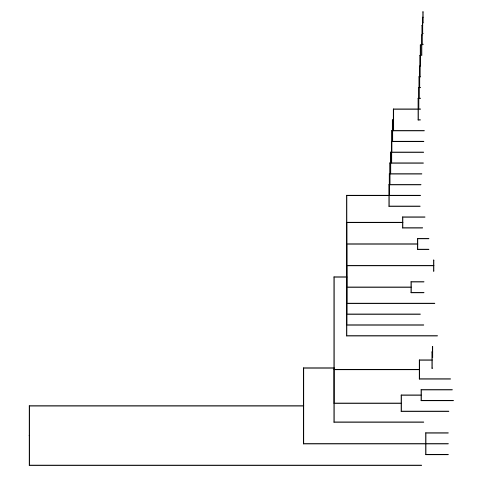

In [32]:
%%R
library(ggtree)
library(treeio)

tree <- read.nexus("/content/timetree/timetree.nexus")
ggtree(tree)

In [40]:
%%R
#install.packages("ggtree")
#install.packages("ape")
#install.packages("dplyr")
#install.packages("ggnewscale")
install.packages("tidyr")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tidyr_1.3.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 809058 bytes (790 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [46]:
!head Dataset1.country.csv  #created a csv offline and uploaded

"name,country,region"
"A/Bald_Eagle/BC/OTH-33-36/2022_H5N1|A/Bald_Eagle/BC/OTH-33-36/2022|2022-02-03|,BC,Canada"
"A/chicken/Aomori/21C14T/2022|2022-04-14|,Aomori,Japan"
"A/Chicken/BC/FAV-0369-OS/2022|2.3.4.4b|2022-03-05|,BC,Canada"
"A/chicken/Iwate/21A1T/2022|2022-02-11|,Iwate,Japan"
"A/chicken/Iwate/21A2T/2022|2022-02-11|,Iwate,Japan"
"A/chicken/Iwate/21A7T/2022|2022-02-11|,Iwate,Japan"
"A/chicken/Iwate/21A13T/2022|2022-02-11|,Iwate,Japan"
"A/chicken/Japan/TU16-1112/2022|2022-02-12|,Japan,Japan"
"A/chicken/Japan/TU20-2829/2022|2022-04-16|,Japan,Japan"


In [58]:
%%R
# Load libraries
# Load libraries
# Load libraries
library(ggtree)
library(ape)
library(dplyr)
library(ggnewscale)
library(tidyr)



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


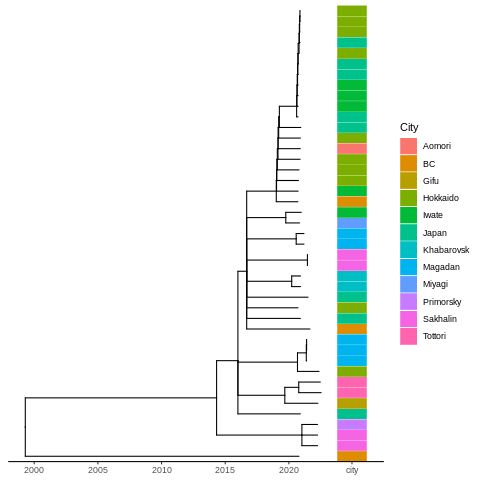

In [74]:
%%R
# Load the tree and metadata
tree <- read.nexus("/content/timetree/timetree.nexus")
country_metadata <- read.csv("Dataset1.country.csv", sep = ",")
name_date_metadata <- read.csv("Dataset1.metadata")


country_metadata <- country_metadata %>%
  separate(name.country.region, into = c("name", "city", "country"), sep = ",")
colnames(country_metadata)

# merge based on the 'name' field
metadata_full <- merge(country_metadata, name_date_metadata, by = "name")

# Rename 'name' column in metadata to 'label'
metadata_full <- metadata_full %>% rename(label = name)

p <- ggtree(tree, mrsd="2022-07-14") +
  theme_tree2()

# Convert metadata to a format suitable
rownames(metadata_full) <- metadata_full$label
metadata_full <- metadata_full %>% select(-label)  # Remove label column since it's now rownames

# Create a heatmap next to the tree
p_heatmap <- gheatmap(p, metadata_full %>% select(city), width = 0.1, offset=.1, colnames = FALSE, colnames_offset_y = .25, legend_title = "City") +
  scale_x_ggtree() +
  new_scale_fill()


# Display the plot with heatmap
p_heatmap


### Divergence times confidence intervals


In [44]:
!treetime --tree Dataset1.aln.treefile.contree --dates Dataset1.metadata --aln Dataset1.aln --outdir timetree-confidence --confidence --covariation  #changed input to contree


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'date' as date.

0.00	-TreeAnc: set-up

0.26	TreeTime.reroot: with method or node: least-squares

0.26	TreeTime.reroot: rerooting will ignore covariance and shared ancestry.

0.36	TreeTime.reroot: with method or node: least-squares

0.36	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

0.54	###TreeTime.run: INITIAL ROUND

1.26	TreeTime.reroot: with method or node: least-squares

1.26	TreeTime.reroot: rerooting will account for covariance and shared ancestry.

1.37	###TreeTime.run: rerunning timetree after rerooting

2.17	###TreeTime.run: ITERATION 1 out of 2 iterations

2.17	DEPRECATION WARNING. TreeTime.resolve_polytomies: You are resolving
    	polytomies using the old 'greedy' mode. This is not well suited for large
    	polytomies. Stochastic resolution will become the default in future
    	versions. To switch now, rerun with the flag

In [45]:
!zip -r BINF90004-phylo.zip .

from google.colab import files
files.download("BINF90004-phylo.zip")

  adding: .config/ (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/active_config (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2024.10.17/ (stored 0%)
  adding: .config/logs/2024.10.17/13.21.11.207512.log (deflated 57%)
  adding: .config/logs/2024.10.17/13.20.28.159945.log (deflated 93%)
  adding: .config/logs/2024.10.17/13.20.49.100599.log (deflated 58%)
  adding: .config/logs/2024.10.17/13.21.10.553091.log (deflated 57%)
  adding: .config/logs/2024.10.17/13.21.00.148611.log (deflated 57%)
  adding: .config/logs/2024.10.17/13.20.58.994073.log (deflated 85%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/default_confi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>